In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.io import imread_collection
from pathlib import Path
import itertools
import cv2


%matplotlib inline

/Users/kasey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Deep Drink
Using image inpainting to censor images of alcoholic beverages.

## Pre-processing: Loading Data

In [101]:
# Load images from the local images folder
# Images downloaded from Open Images using 
# https://github.com/EscVM/OIDv4_ToolKit
def load_images():
    img_dir = 'testimages/*.jpg'
    img_col = imread_collection(img_dir)
    final_col = []
    img_files = [x.replace("testimages/", "")[:-4] for x in img_col.files]
    for (img, fn) in zip(img_col, img_files):
        img = img/255.
        #img_resize = resize(img, output_shape=(num_px, num_px), mode='constant')
        final_col.append((fn, img))
    return final_col

In [102]:
# Load images into a collection
images = load_images()

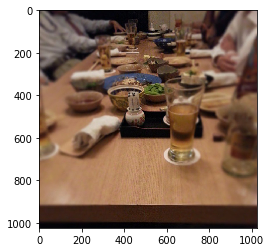

In [103]:
# Example of a picture
index = 1
plt.imshow(images[index][1])

## Object Detection with YOLO
The following section was adapted from https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html.


Using "beer" images from Open Images and this open source project (https://github.com/WyattAutomation/Train-YOLOv3-with-OpenImagesV4), we created a set of training images with bounding boxes. Then we altered the Darknet/Yolo project to train and detect a single class ("beer"). The weights for the model ended up plateauing around an accuracy of ~0.5 (with learning rate .001, batches of 16. 

In [104]:
# Adapted from https://www.arunponnusamy.com/yolo-object-detection-opencv-python.html

pretrained_weights = '/Users/kasey/Desktop/StanfordGSB/DeepDrink/FinalTraining/beer_10000.weights'
config_file = '/Users/kasey/Desktop/StanfordGSB/DeepDrink/beer.cfg'
classes_raw = '/Users/kasey/Desktop/StanfordGSB/DeepDrink/beer.txt'
#image = cv2.imread('testimages/0a38941cedcf3e16.jpg',3)
image = cv2.imread('testimages/00a08059ad2d7637.jpg',3)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Width = image.shape[1]
Height = image.shape[0]
scale = 0.005

# read class names from text file
classes = None
g = open(classes_raw, 'r')

with open(classes_raw, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# generate different colors for different classes 
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

# read pre-trained model and config file
net = cv2.dnn.readNet(pretrained_weights, config_file)

# create input blob 
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

# set input blob for the network
net.setInput(blob)

In [105]:
# function to get the output layer names 
# in the architecture
def get_output_layers(net):
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    return output_layers

# function to draw bounding box on the detected object with class name
def draw_bounding_box(img, class_id, confidence, x, y, x_plus_w, y_plus_h):
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 5)
    

In [106]:
# run inference through the network
# and gather predictions from output layers
outs = net.forward(get_output_layers(net))

# initialization
class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4

# for each detetion from each output layer 
# get the confidence, class id, bounding box params
# and ignore weak detections (confidence < 0.5)
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])

1
169.0 359.5 96 305
0
655.5 355.0 93 260


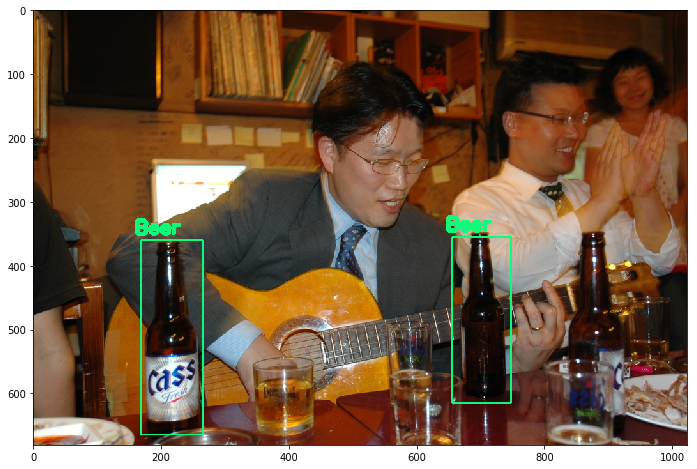

In [159]:
# apply non-max suppression
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
img_bb = image.copy()

# go through the detections remaining
# after nms and draw bounding box
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    print(i)
    print(x,y,w,h)
    
    draw_bounding_box(img_bb, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

#  display output image  
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img_bb)


## Image Inpainting

### Drawing the image mask

In [176]:
def draw_mask(img, class_id, confidence, x, y, x_plus_w, y_plus_h): 
    label = str(classes[class_id])
    color = COLORS[class_id]
    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), [255, 255, 255], -1)
    
def blank_img(img):
    img2 = img.copy()
    height, width = img2.shape[:2]
    print(img2.shape)
    cv2.rectangle(img2, (0,0), (width, height), [0,0,0], -1)
    return img2


(681, 1024, 3)
1
169.0 359.5 96 305
0
655.5 355.0 93 260


True

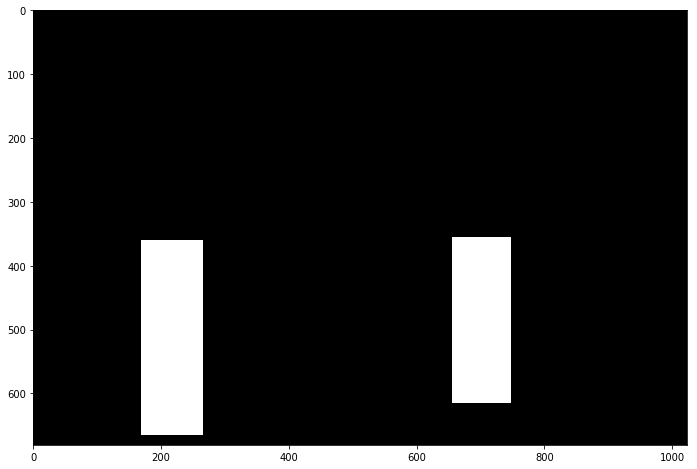

In [177]:
# go through the detections remaining
# after nms and draw mask
#img_gray = cv2.cvtColor(img_msk, cv2.COLOR_BGR2GRAY)
#(thresh, blackAndWhiteImage) = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
img_msk = image.copy()
img_blank = blank_img(img_msk)

for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    print(i)
    print(x,y,w,h)
    draw_mask(img_blank, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))
    #draw_mask(img_blank, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h))

#  display output image  
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(img_blank)
cv2.imwrite('beerMask.jpg', img_blank)


In [178]:
mask = cv2.imread('beerMask.jpg', 0)
dst = cv2.inpaint(img_msk,mask,3,cv2.INPAINT_NS)
dst2 = cv2.inpaint(img_msk,mask,3, cv2.INPAINT_TELEA)

### The Mask

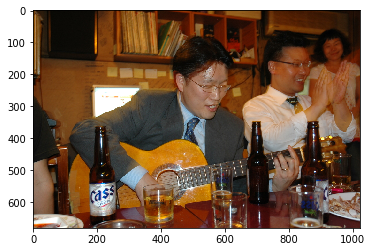

In [179]:
plt.imshow(img_msk)

### The Navier-Stokes Method

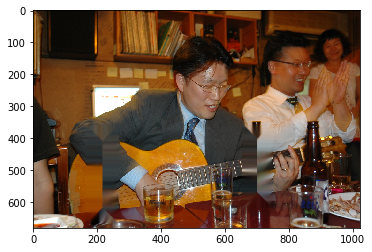

In [180]:
plt.imshow(dst)

### Method by Alexandru Telea

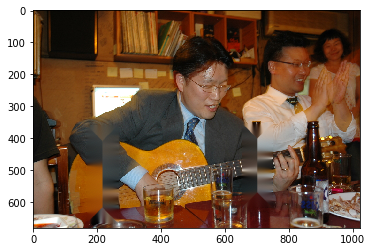

In [181]:
plt.imshow(dst2)